# Import all libraries ###

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# Load the data

In [2]:
df = pd.read_csv("heart.csv")

# Exploratory Data Analysis

Dataset shape: (918, 12)

Missing values:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Class distribution:
HeartDisease
1    508
0    410
Name: count, dtype: int64


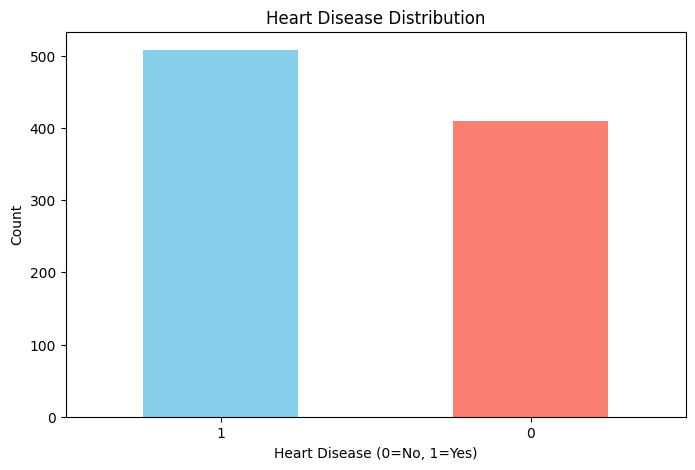

In [4]:
print(f"Dataset shape: {df.shape}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nClass distribution:\n{df['HeartDisease'].value_counts()}")
df.head()
df.describe()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
df['HeartDisease'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Heart Disease Distribution')
plt.xlabel('Heart Disease (0=No, 1=Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Label Encoding

In [5]:
# Label encoding

df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})
df['ChestPainType'] = df['ChestPainType'].map({'ASY': 1000, 'ATA': 1001,'NAP': 1002,'TA': 1003})
df['RestingECG'] = df['RestingECG'].map({'LVH': 10, 'Normal':11,'ST': 12})
df['ExerciseAngina'] = df['ExerciseAngina'].map({'N': 100, 'Y': 101})
df['ST_Slope'] = df['ST_Slope'].map({'Down': 2000, 'Flat': 2001,'Up':2002})


# Remove NaN rows

In [34]:
# remove the NaN row from one of the columns:

df = df.dropna(subset=['ExerciseAngina'])

#df = df.dropna() 


# Info of the data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    int64  
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 86.2 KB


# Head of the data - first 5 rows

In [7]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1001,140,289,0,11,172,100,0.0,2002,0
1,49,0,1002,160,180,0,11,156,100,1.0,2001,1
2,37,1,1001,130,283,0,12,98,100,0.0,2002,0
3,48,0,1000,138,214,0,11,108,101,1.5,2001,1
4,54,1,1002,150,195,0,11,122,100,0.0,2002,0


# Split and Train Data

In [13]:
# Separate features (X) and target (y)
X = df.drop(columns='HeartDisease', axis=1)
y = df['HeartDisease']

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# step 1 - 80-20 split of whole data set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# step 2 - from the 80 split - 75% for train, and 25% towardss dev or devtest
X_train, X_dev, y_train, y_dev = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)


# Verify the shapes of the new datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("y_dev shape:", y_dev.shape)
print("X_dev shape:", X_dev.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_dev_scaled = scaler.transform(X_dev)


X_train shape: (550, 11)
y_train shape: (550,)
y_dev shape: (184,)
X_dev shape: (184, 11)


# Quick test with dev test data:

In [23]:
# === NEW SECTION: Hyperparameter Tuning on Dev Set ===

print("\n=== Tuning C parameter on Dev Set ===")
c_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
best_c = None
best_dev_recall = 0
results = []

for c in c_values:
    # Train model with this C value
    model = LogisticRegression(C=c, class_weight='balanced', max_iter=1000)
    model.fit(X_train_scaled, y_train)
    
    # Evaluate on DEV set (NOT test!)
    y_dev_pred = model.predict(X_dev_scaled)
    dev_acc = accuracy_score(y_dev, y_dev_pred)
    dev_prec = precision_score(y_dev, y_dev_pred)
    dev_rec = recall_score(y_dev, y_dev_pred)
    dev_f1 = f1_score(y_dev, y_dev_pred)
    
    results.append({
        'C': c,
        'Dev_Accuracy': dev_acc,
        'Dev_Precision': dev_prec,
        'Dev_Recall': dev_rec,
        'Dev_F1': dev_f1
    })
    
    print(f"C={c:>5}: Acc={dev_acc:.3f}, Prec={dev_prec:.3f}, Rec={dev_rec:.3f}, F1={dev_f1:.3f}")
    
    # Track best C (optimize for recall in medical context)
    if dev_rec > best_dev_recall:
        best_dev_recall = dev_rec
        best_c = c

print(f"\n✅ Best C (highest recall): {best_c} with Dev Recall={best_dev_recall:.3f}")

# === Retrain on Train + Dev Combined ===
print("\n=== Retraining on Train + Dev Combined ===")

# Combine train and dev for final training
X_train_dev_scaled = np.vstack([X_train_scaled, X_dev_scaled])
y_train_dev = np.concatenate([y_train, y_dev])

# Train final model with best C
final_model = LogisticRegression(C=best_c, class_weight='balanced', max_iter=1000)
final_model.fit(X_train_dev_scaled, y_train_dev)

# === Final Evaluation on Test Set (ONLY ONCE) ===
print("\n=== Final Test Set Evaluation ===")

y_test_pred = final_model.predict(X_test_scaled)

test_acc = round(accuracy_score(y_test, y_test_pred), 3)
test_prec = round(precision_score(y_test, y_test_pred), 3)
test_rec = round(recall_score(y_test, y_test_pred), 3)
test_f1 = round(f1_score(y_test, y_test_pred), 3)
test_cm = confusion_matrix(y_test, y_test_pred)

print(f"Accuracy: {test_acc}")
print(f"Precision: {test_prec}")
print(f"Recall: {test_rec}")
print(f"F1: {test_f1}")
print(f"Confusion Matrix:\n{test_cm}")

# Train vs Test comparison
y_train_dev_pred = final_model.predict(X_train_dev_scaled)
train_dev_acc = round(accuracy_score(y_train_dev, y_train_dev_pred), 3)

print(f"\n=== Training vs Test Comparison ===")
print(f"Training Accuracy: {train_dev_acc}")
print(f"Test Accuracy: {test_acc}")

if train_dev_acc - test_acc > 0.1:
    print("⚠️ Possible overfitting")
elif train_dev_acc < 0.75 and test_acc < 0.75:
    print("⚠️ Possible underfitting")
else:
    print("✅ Good generalization")


=== Tuning C parameter on Dev Set ===
C=  0.1: Acc=0.891, Prec=0.884, Rec=0.934, F1=0.908
C=  0.5: Acc=0.891, Prec=0.884, Rec=0.934, F1=0.908
C=  1.0: Acc=0.886, Prec=0.883, Rec=0.925, F1=0.903
C=  2.0: Acc=0.886, Prec=0.883, Rec=0.925, F1=0.903
C=  5.0: Acc=0.886, Prec=0.883, Rec=0.925, F1=0.903
C= 10.0: Acc=0.886, Prec=0.883, Rec=0.925, F1=0.903

✅ Best C (highest recall): 0.1 with Dev Recall=0.934

=== Retraining on Train + Dev Combined ===

=== Final Test Set Evaluation ===
Accuracy: 0.832
Precision: 0.913
Recall: 0.785
F1: 0.844
Confusion Matrix:
[[69  8]
 [23 84]]

=== Training vs Test Comparison ===
Training Accuracy: 0.857
Test Accuracy: 0.832
✅ Good generalization


# First 5 rows of X and y train

In [15]:
# print first five elements of X train
print("First five elements in X_train are:\n", X_train[:5])
print("Type of X_train:",type(X_train))

# print first five elements of y train
print("First five elements in y_train are:\n", y_train[:5])
print("Type of y_train:",type(y_train))

# print first five elements of y train
print("First five elements in y_dev are:\n", y_train[:5])
print("Type of y_dev:",type(y_train))

# print first five elements of y train
print("First five elements in X_dev are:\n", y_train[:5])
print("Type of X_dev:",type(y_train))




First five elements in X_train are:
      Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
364   56    1           1002        120            0          0          11   
98    56    1           1000        120           85          0          11   
600   57    1           1000        130          207          0          12   
201   46    1           1002        120          230          0          11   
345   69    1           1000        135            0          0          11   

     MaxHR  ExerciseAngina  Oldpeak  ST_Slope  
364     97             100      0.0      2001  
98     140             100      0.0      2002  
600     96             101      1.0      2001  
201    150             100      0.0      2002  
345    130             100      0.0      2001  
Type of X_train: <class 'pandas.core.frame.DataFrame'>
First five elements in y_train are:
 364    0
98     0
600    0
201    0
345    1
Name: HeartDisease, dtype: int64
Type of y_train: <class 'panda

# Check the dimensions of your variables

In [16]:
print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('The shape of y_dev is: ' + str(y_dev.shape))
print ('The shape of X_dev is: ' + str(X_dev.shape))
print ('We have m = %d training examples' % (len(y_train)))

The shape of X_train is: (550, 11)
The shape of y_train is: (550,)
The shape of y_dev is: (184,)
The shape of X_dev is: (184, 11)
We have m = 550 training examples


# Model implementation - Import libraries, create model, weight, iterations, and fit the model

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

model = LogisticRegression(C=1, class_weight='balanced', max_iter=1000)

In [19]:
model.fit(X_train_scaled, y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=1000)

# Prediction Step - Predict on training data

In [20]:
#model.predict on X test data

y_pred = model.predict(X_test_scaled)

# Metrics - Import libraries and run metrics on the prediction

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [22]:

acc = round(accuracy_score(y_test, y_pred), 3)
prec = round(precision_score(y_test, y_pred), 3)
rec = round(recall_score(y_test, y_pred), 3)
f1_score_value = round(f1_score(y_test, y_pred), 3)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1: {f1_score_value}")
print(f"Confusion Matrix:\n{cm}")

# Make predictions on training set
y_train_pred = model.predict(X_train_scaled)
train_acc = round(accuracy_score(y_train, y_train_pred), 3)

print(f"\n=== Training vs Test Comparison ===")
print(f"Training Accuracy: {train_acc}")
print(f"Test Accuracy: {acc}")

# Diagnostic check
if train_acc - acc > 0.1:
    print("⚠️ Possible overfitting (train accuracy >> test accuracy)")
elif train_acc < 0.75 and acc < 0.75:
    print("⚠️ Possible underfitting (both accuracies low)")
else:
    print("✅ Good generalization (train and test similar)")

Accuracy: 0.837
Precision: 0.905
Recall: 0.804
F1: 0.851
Confusion Matrix:
[[68  9]
 [21 86]]

=== Training vs Test Comparison ===
Training Accuracy: 0.849
Test Accuracy: 0.837
✅ Good generalization (train and test similar)


# Final step - Save the model and features

In [16]:
import joblib

# Save everything
joblib.dump(model, 'heart_disease_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X.columns.tolist(), 'feature_columns.pkl')

print("Model, scaler, and feature columns saved!")

Model, scaler, and feature columns saved!


In [17]:
print(X_train.columns.tolist())

['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']
